In [1]:
import json

import pandas as pd
from datasets import load_dataset
import evaluate
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

In [2]:
# This doesn't work
# target_spider = TARGET(("Text to SQL Task", "spider-test"))
# dataset = target_spider.create_dataloaders(target_spider.dataset_info)['spider-test']
# next(dataset.get_queries_for_task())

In [3]:
all_tasks_to_rankwise_metrics = {}

In [4]:
def load_jsonl(filepath: str):
    data = []
    with open(filepath) as f:
        for line in f:
            data.append(json.loads(line))
    return data

def get_normalized_answer(answer: str):
    if "true" in answer.lower():
        return 1
    elif "false" in answer.lower():
        return 0
    else:
        return -1
    
def save_figures(df, metric_col, dataset_name, split, y_label, agg, all_tasks_to_rankwise_metrics):
    df['bin'] = pd.cut(
    df['gold_table_rank'], 
        bins=[0, 2, 4, 6, 8, 10], 
        include_lowest=True,
        labels=["1-2", "3-4", "5-6", "7-8", "9-10"]
    )
    df['bin'] = df['bin'].cat.add_categories(["N.A."])
    df['bin'] = df['bin'].fillna("N.A.")
    if agg == 'mean':
        rankwise_metrics = pd.DataFrame(df.groupby('bin')[metric_col].mean()).reset_index()
    else:
        rankwise_metrics = pd.DataFrame(df.groupby('bin')[metric_col].sum() / df.groupby('bin')[metric_col].count()).reset_index()
    num_rankwise_datapoints = pd.DataFrame(df.groupby('bin')[metric_col].count()).reset_index()
    
    sns.set(style="white")
    fig, ax = plt.subplots(figsize=(5, 5))
    ax = sns.barplot(
        rankwise_metrics,
        x="bin",
        y=metric_col,
        color="lightblue"
    )
    plt.tight_layout()
    ax.set_xlabel("Rank of Gold Table in Retrieval Results")
    ax.set_ylabel(y_label)
    plt.title(f"{dataset_name} {split} Performance", fontsize=18)
    plt.show()
    sns.barplot(num_rankwise_datapoints, x="bin", y=metric_col)
    plt.title(f"{dataset_name} Bin counts")
    plt.show()
    
    all_tasks_to_rankwise_metrics[dataset_name] = rankwise_metrics
    return all_tasks_to_rankwise_metrics

# TabFact

/var/folders/p3/pk7r1kyd2ddg581sqwh4k1xm0000gn/T/ipykernel_36151/1845149672.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rankwise_metrics = pd.DataFrame(df.groupby('bin')[metric_col].sum() / df.groupby('bin')[metric_col].count()).reset_index()
/var/folders/p3/pk7r1kyd2ddg581sqwh4k1xm0000gn/T/ipykernel_36151/1845149672.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  num_rankwise_datapoints = pd.DataFrame(df.groupby('bin')[metric_col].count()).reset_index()


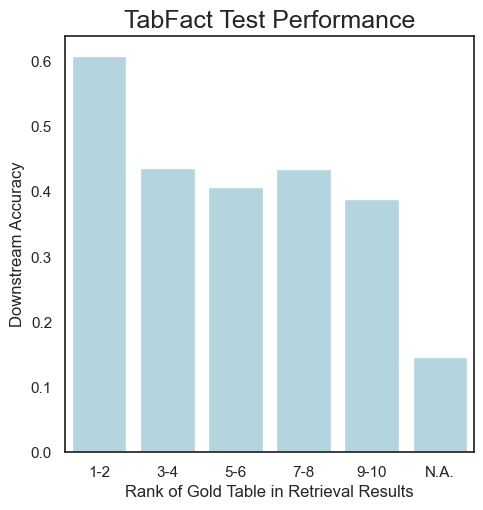

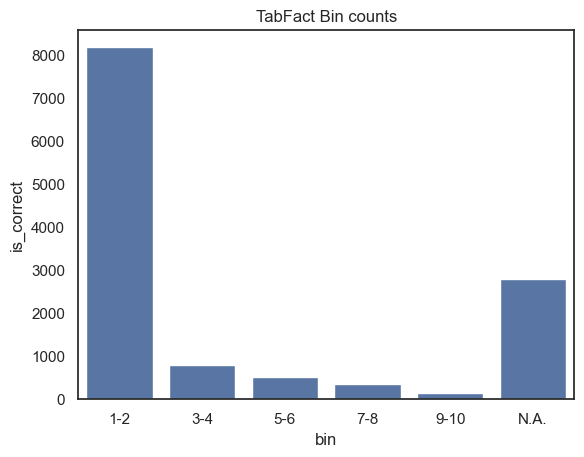

In [9]:
downstream_data = load_jsonl(f'../data/eval-results/downstream/hnsw_openai_title_only/tabfact/10.jsonl')
retrieval_data = load_jsonl(f'../data/eval-results/retrieval/hnsw_openai_headers_only/tabfact/tabfact_10.jsonl')
dataset = load_dataset("target-benchmark/tabfact-queries")['test']
assert len(set([len(x) for x in [downstream_data, retrieval_data, dataset]])) == 1
# Join all the above info into one List[dict] objects
data = []
for idx in range(len(dataset)):
    to_add = {
        "gold_database_id": dataset[idx]["database_id"],
        "gold_table_id": dataset[idx]["table_id"],
        "gold_answer":  get_normalized_answer(dataset[idx]["answer"]),
        **retrieval_data[idx],
        **downstream_data[idx],
        "generated_results": get_normalized_answer(downstream_data[idx]['generated_results']),
    }
    assert len(set([x['query_id'] for x in [downstream_data[idx], retrieval_data[idx], dataset[idx]]])) == 1
    data.append(to_add)
df_dict = []
for item in data:
    to_add = {
        "gold_table_rank": -1,
        "is_correct": None
    }
    gold_table_id = item['gold_table_id']
    gold_database_id = item['gold_database_id']
    if [gold_database_id, gold_table_id] in item['retrieval_results']:
        to_add['gold_table_rank'] = item['retrieval_results'].index([gold_database_id, gold_table_id])
    to_add['is_correct'] = item['gold_answer'] == item['generated_results']
    df_dict.append(to_add)
df = pd.DataFrame(df_dict)
all_tasks_to_rankwise_metrics = save_figures(
    df=df,
    metric_col='is_correct',
    agg='percentage',
    y_label='Downstream Accuracy',
    dataset_name='TabFact',
    split='Test',
    all_tasks_to_rankwise_metrics=all_tasks_to_rankwise_metrics
)

# FetaQA and OTTQA

  0%|          | 0/2003 [00:00<?, ?it/s]

/var/folders/p3/pk7r1kyd2ddg581sqwh4k1xm0000gn/T/ipykernel_36151/1845149672.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rankwise_metrics = pd.DataFrame(df.groupby('bin')[metric_col].mean()).reset_index()
/var/folders/p3/pk7r1kyd2ddg581sqwh4k1xm0000gn/T/ipykernel_36151/1845149672.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  num_rankwise_datapoints = pd.DataFrame(df.groupby('bin')[metric_col].count()).reset_index()


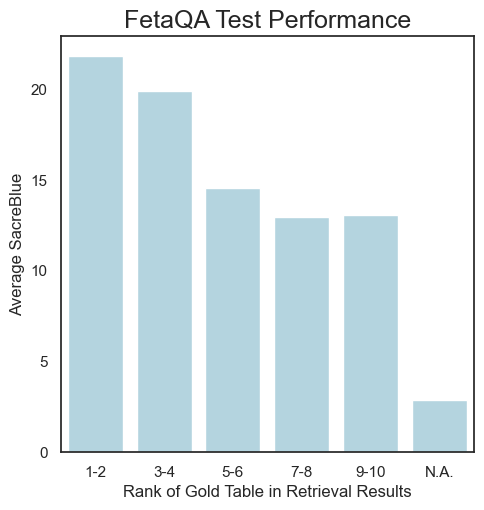

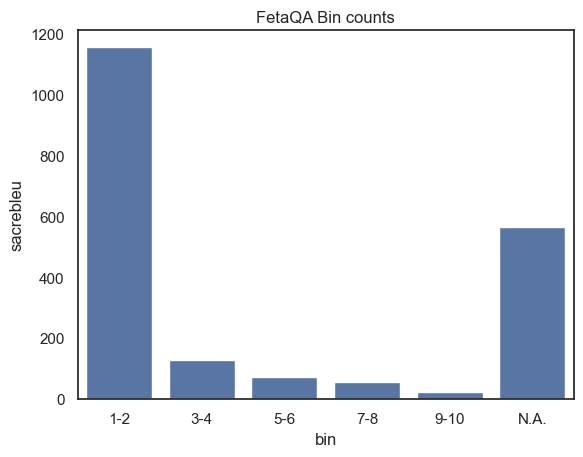

  0%|          | 0/2214 [00:00<?, ?it/s]

/var/folders/p3/pk7r1kyd2ddg581sqwh4k1xm0000gn/T/ipykernel_36151/1845149672.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rankwise_metrics = pd.DataFrame(df.groupby('bin')[metric_col].mean()).reset_index()
/var/folders/p3/pk7r1kyd2ddg581sqwh4k1xm0000gn/T/ipykernel_36151/1845149672.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  num_rankwise_datapoints = pd.DataFrame(df.groupby('bin')[metric_col].count()).reset_index()


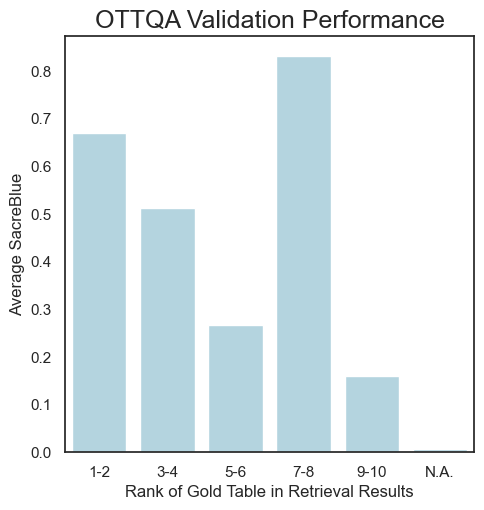

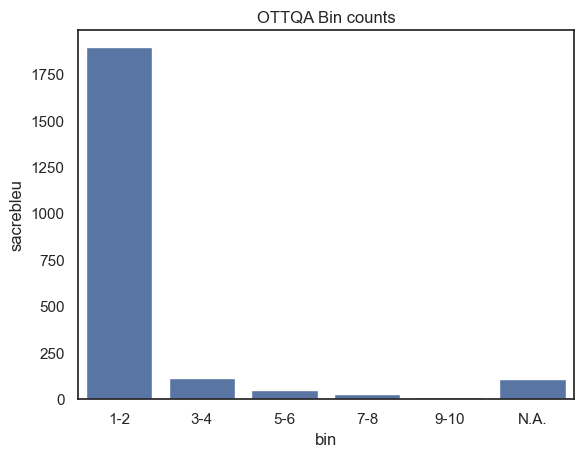

In [12]:
for dataset_name, split in [
    ('FetaQA', 'Test'), 
    ('OTTQA', 'Validation')
]:
    downstream_data = load_jsonl(f'../data/eval-results/downstream/hnsw_openai_title_only/{dataset_name.lower()}/10.jsonl')
    retrieval_data = load_jsonl(f'../data/eval-results/retrieval/hnsw_openai_headers_only/{dataset_name.lower()}/{dataset_name.lower()}_10.jsonl')
    dataset = load_dataset(f"target-benchmark/{dataset_name.lower()}-queries")[split.lower()]
    assert len(set([len(x) for x in [downstream_data, retrieval_data, dataset]])) == 1
    sacrebleu = evaluate.load("sacrebleu", keep_in_memory=True)
    # Join all the above info into one List[dict] objects
    data = []
    for idx in tqdm(range(len(dataset))):
        if len(data) > idx:
            continue
        to_add = {
            "gold_database_id": dataset[idx]["database_id"],
            "gold_table_id": dataset[idx]["table_id"],
            "gold_answer":  dataset[idx]["answer"],
            **retrieval_data[idx],
            **downstream_data[idx],
            "generated_results": downstream_data[idx]['generated_results'],
            "sacrebleu": sacrebleu.compute(predictions=[downstream_data[idx]['generated_results']], references=[[dataset[idx]["answer"]]])['score'] 
        }
        assert len(set([x['query_id'] for x in [downstream_data[idx], retrieval_data[idx], dataset[idx]]])) == 1
        data.append(to_add)
    df_dict = []
    for item in data:
        to_add = {
            "gold_table_rank": -1,
            "sacrebleu": item["sacrebleu"]
        }
        gold_table_id = item['gold_table_id']
        gold_database_id = item['gold_database_id']
        if [gold_database_id, gold_table_id] in item['retrieval_results']:
            to_add['gold_table_rank'] = item['retrieval_results'].index([gold_database_id, gold_table_id])
        df_dict.append(to_add)
    df = pd.DataFrame(df_dict)
    all_tasks_to_rankwise_metrics = save_figures(
        df=df,
        metric_col='sacrebleu',
        agg='mean',
        y_label='Average SacreBlue',
        dataset_name=dataset_name,
        split=split,
        all_tasks_to_rankwise_metrics=all_tasks_to_rankwise_metrics
    )

In [13]:
idx = 4
print(f"Question: '{dataset[idx]['query']}'")
print(f"Gold Answer: '{dataset[idx]['answer']}'")
print(f"Predicted: '{downstream_data[4]['generated_results']}'")

Question: 'How many academic staff are at the university in Budapest that has the official abbreviation BME ?'
Gold Answer: '961'
Predicted: 'The university in Budapest with the official abbreviation BME is the Budapest University of Technology and Economics. It has 961 academic staff.'


# Spider and BIRD

In [8]:
all_tasks_to_rankwise_metrics['OTTQA']

,bin,sacrebleu
0,1-2,0.670211
1,3-4,0.513184
2,5-6,0.267055
3,7-8,0.831469
4,9-10,0.160443
5,N.A.,0.006495


In [37]:
from scipy import stats
all_results = []
# Spearman measures monotonic relationships - increase/decrease together, but not at constant rate
# pearson is linear - same rates are assumed
rank_order = ["1-2", "3-4", "5-6", "7-8", "9-10", "N.A."]
for task, df in all_tasks_to_rankwise_metrics.items():
    metric_col = [i for i in df.columns if i != 'bin'][0]
    x = []
    y = []
    for idx, rank in enumerate(rank_order):
        x.append(idx)
        y.append(df[df['bin'] == rank][metric_col].item())
    result = stats.spearmanr(x, y).statistic
    print(f"Spearman r for {task}: {result}")
    all_results.append(float(result))
np.array(all_results).mean()

Spearman r for TabFact: -0.942857142857143
Spearman r for FetaQA: -0.942857142857143
Spearman r for OTTQA: -0.6571428571428573


-0.8476190476190477

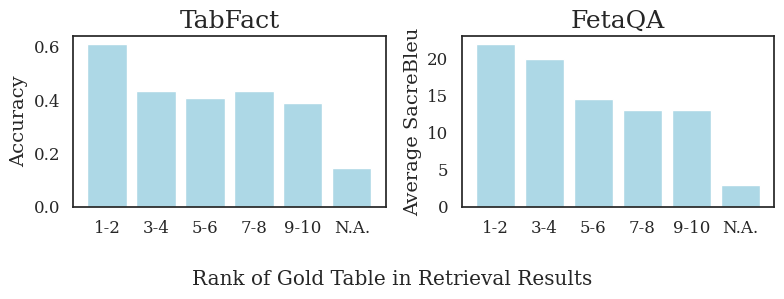

In [14]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12) #fontsize of the legend
plt.rc('axes', labelsize=14)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), sharex=True)
df = all_tasks_to_rankwise_metrics['TabFact']

axes[0].bar(
    df["bin"],
    df["is_correct"],
    color="lightblue"
)
axes[0].set_ylabel("Accuracy")
axes[0].set_title(f"TabFact", fontsize=18)
axes[0].tick_params(axis='both')

df = all_tasks_to_rankwise_metrics['FetaQA']
axes[1].bar(
    df["bin"],
    df["sacrebleu"],
    color="lightblue"
)
axes[1].set_ylabel("Average SacreBleu")
axes[1].set_title(f"FetaQA", fontsize=18)
axes[1].tick_params(axis='both')

fig.supxlabel("Rank of Gold Table in Retrieval Results")
plt.tight_layout()

fig.savefig('retriever-rank-barcharts.pdf', format="pdf", bbox_inches="tight", dpi=150)